# TODO

1. Trovare un modo per valutare la distanza tra i break points trovati e quelli originali XXX
2. Effettuare valutazione su differenti testi
3. Utilizzare una versione più grande di glove
4. Refactoring codice XXX + commenti 
5. Scrittura  markdown 

# Esercitazione 4: Text Segmentation

In questa esercitazione vedremo come implementare un algoritmo per la segmentazione di un documento testuale in *unità informative coerenti*.

Tra i molteplici approcci proposti in letteratura, si è scelto di implementare un algoritmo basato sul *Text Tiling* proposto da  [M. A. Hearst](https://www.aclweb.org/anthology/J97-1003.pdf).

In [1]:
from pathlib import Path
import nltk
import numpy as np

import src.data_manager as dm
import src.text_segmentation as segm
import src.viz as viz

import matplotlib.pyplot as plt

plt.style.use('seaborn')

[nltk_data] Downloading package punkt to /home/prf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/prf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dati 
I 5 documenti scelti per l'esercitazione, sono stati campionati in **modo casuale** da un sottoinsieme di 100 documenti presenti nel dataset [WIKI-727K](https://arxiv.org/pdf/1803.09337.pdf). Il dataset è composto da una collezione di $727,746$ documenti di Wikipedia in lingua Inglese. Ogni documento è diviso in "sezioni tematiche", la cui fine, è contassegnata dal pattern simbolico .


La classe data.Document rappresenta il principale oggetto di lavoro. I metodi implementati, permettono di effettuare il parsing del documento, la divisione in *chunks* e l'estrazione dei separatori delle sezioni.

I **chunks** sono le unità informativa di base processate dall'algoritmo. La natura del chunk dipende dal **livello di granularità** scelto (parole, frasi, paragrafi, ecc. ). Per rendere l'algoritmo agnostico e trasparente dalla granularità scelta, duarante la creazione dell'istanza Document, viene dato input una funzione *tokenizer* che implementa la logica di tokenizzazione. In questa esercitazione si è scelto di lavorare a livello di frasi, dunque, un chunk è una frase.

Inoltre le annotazioni che demarcano la fine di una sezione, che qui chiameremo rispettivamente breakpoints e blocchi, sono di fondamentale importanza per la fase di valutazione. Come riportato da [M. A. Hearst](https://www.aclweb.org/anthology/J97-1003.pdf] non possiamo assumere che la **separazione del testo in paragrafi** sia informativa per il task in questione e dunque che ogni paragrafo rappresenti **un'unità informativa coerente**. A differenze di quanto "ci viene insegnato a scuola", spesso le persone tendono a dividere il contenuto in paragrafi sulla base di un criterio "estetico-strutturale" piuttosto che coerente dal punto di vista informativo.




In [2]:
doc = dm.Document(Path('data/test_doc.txt'), nltk.sent_tokenize, search_title=True)

title = doc.title.split(".")[0] # get first part of the title

print(f'Document title: "{title} ..."\n')

N = 10
chunks = '\n'.join(doc.get_chunks()[0:N])
print(f"Document's first {N} chunks:\n{chunks}\n")
print(f"Document's blocks breakpoints:{doc.get_breakpoints()}")

Document title: "Associative Memory, habits are conditioned ..."

Document's first 10 chunks:
I used to love burgers from McDonald's.
I was skinny six-year-old, with flat cheeks and wide eyes.
You wouldn't have expected me to fit two bites down my throat.
But somehow, I had the capacity to devour two whole burgers of fast food junk.
My mother was always aghast watching me down a meal for two adults — I was barely out of kindergarten, after all.
Then, one day, when I was in the 3rd grade, my family was travelling back home from a hill station we’d been vacationing at.
I’d been sitting quietly in the back of the car for over five hours, as we braved the torrential rains flooding the mountain range west of our city.
Stuck in the deluge with endless Indian traffic and nowhere to go, we stopped at my favourite place— McDonald’s.
As always, I ordered my usual two burgers.
We received our order while still in the car, and continued the drive towards home.

Document's blocks breakpoints:[(14, 

### Glove embedding

Per valutare la coerenza tra due blocchi è stato utilizzata la *cosine similarity*; di conseguenza bisogna utilizzare una rappresentazione vettoriale. 

Si è scelto di utilizza la risorsa *Glove* come modello di rappresentazione vettoriale. Glove è un **word embedding** ottenuto dal training non supervisionato sulla **matrice di co-occorrenza word-word**. Ogni entry della matrice rappresenta quanto frequentemente un parola co-occorre con un'altra nel corpus

L'idea alla base di Glove nasce da una semplice osservazione, la probabilità di co-occorrenza,potenzialmente codifica una "qualche forma di significato" tra le parole coinvolte:

![](https://nlp.stanford.edu/projects/glove/images/table.png)


L'obiettivo di Glove è creare uno spazio in cui il prodotto scalare tra 2 vettori è uguale al logaritmo delle probabilità delle co-occorenze delle due parole associate.

La classe data.Glove rappresenta un semplice wrapper per caricare in memoria ed accedere ai vettori dell'embdedding. 

Vediamo dei semplici esempi





In [5]:
glove_path = Path("data/glove.6B.300d.txt")
glove = dm.Glove(glove_path)

In [6]:
word_pairs = [("memory","brain"),("memory","vision"),
              ("vision","brain"), ("brain","lemon")]

for w1, w2 in word_pairs:
    sim = segm.cosine_similarity(glove[w1], glove[w2])
    print(f"{w1}-{w2}: {sim}")


memory-brain: 0.4397561194147497
memory-vision: 0.3179046520575246
vision-brain: 0.30173050373193067
brain-lemon: 0.018542670368901337


## Text segmentation

Il task prevede di segmentare il testo in blocchi coesivi dal punto di vista informativo. Solitamente si cerca di suddividere il testo in modo tale che ogni blocco rappresenti un **sub topic** rispetto all'intero contenuto.

L'approccio utilizzato si basa sull'algoritmo di *Text Tiling*....

L'algoritmo qui proposto si basa sui seguenti principali steps:

1. Suddividere il testo in un prefissato numero blocchi di **lunghezza omogenea**. Ogni blocco contiene (approssimativamente) lo stesso numero di chunks.

2. Calcolare la **similarità tra blocchi adiacenti**. La similarità viene calcolata come **similairtà media** tra tutte le possibili **coppie di chunks**:

    $$(c_n^{i}, c_m^{i+1})$$

    dove i chunks $c_n,c_m$ della coppia appartengono rispettivamente al blocco $B_i$ e il blocco adiacente $B_{i+1}$. Da notare che $n=1,\ldots, |B_i|$ e $m=1,\ldots,|B_{i+1}|$

3. I breakpoints vengono individuati come **minimi locali** della funzione di similarità al variare dei blocchi.

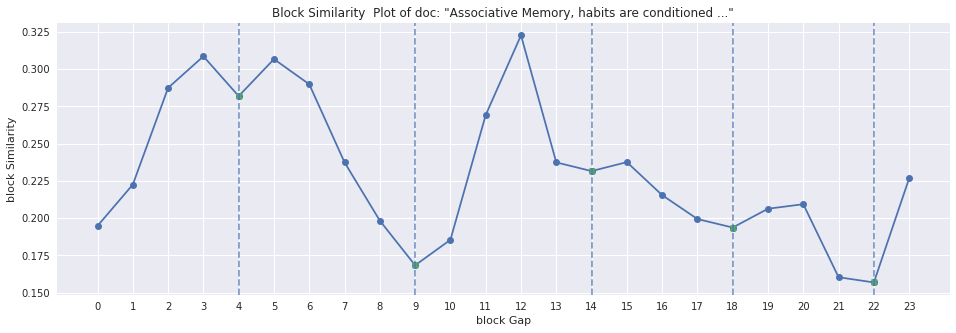

In [7]:
segmenter = segm.TextSegmenter(segm.preprocessor, glove, segm.cosine_similarity)
INITIAL_BLOCKS = 25 # is chosen carefully for demonstration purpose
minima, similarities, blocks = segmenter.segment(doc, initial_blocks=INITIAL_BLOCKS)


fig, ax = plt.subplots(1,1,figsize=(16,5))
viz.block_similarity_plot(ax, doc, minima, similarities)

### TODO 
spiegare l'utilità della funzione valley_to blocks e i due livelli di lavoro chunks-blocks

In [10]:
def valleys_to_breakpoints(valleys, blocks):
    chunks = []

    # from first block to the first break point
    [chunks.extend(block) for block in blocks[0:valleys[0]+1]]
    chunks.append(dm.Document.BLOCK_SEPARATOR)

    for start, end in zip(valleys[0::], valleys[1::]):
        for block in blocks[start+1:end+1]:
            chunks.extend(block)
        chunks.append(dm.Document.BLOCK_SEPARATOR)

    # from last breakpoint to the last block
    [chunks.extend(block) for block in blocks[valleys[-1]+1:]]

    # Search only for breakpoints
    sep_pos = [i for i,chunk in enumerate(chunks) 
                   if chunk == dm.Document.BLOCK_SEPARATOR]
        
    breakpoints_pos = [(pos-1, pos) for pos in sep_pos] # we must take into account that pos when BLOCK_SEPARATOR is removed, is the right index of the next sentence (not pos+1)

    return breakpoints_pos, chunks

In [11]:
valleys, sims, blocks = segmenter.segment(doc, initial_blocks=40)

breakpoints, system_chunks = valleys_to_breakpoints(valleys, blocks)

true_breakpoints = np.array([breakpoint[0] for breakpoint in doc.get_breakpoints()])
system_breakpoints = np.array([breakpoint[0] for breakpoint in breakpoints])

### Evaluation

In [14]:
if len(true_breakpoints) == len(system_breakpoints):
    diff = np.abs(true_breakpoints-system_breakpoints)
    print(f"Avg offset error {diff.mean()}+-{diff.std():.2f}, with min {diff.min()} and max {diff.max()}")

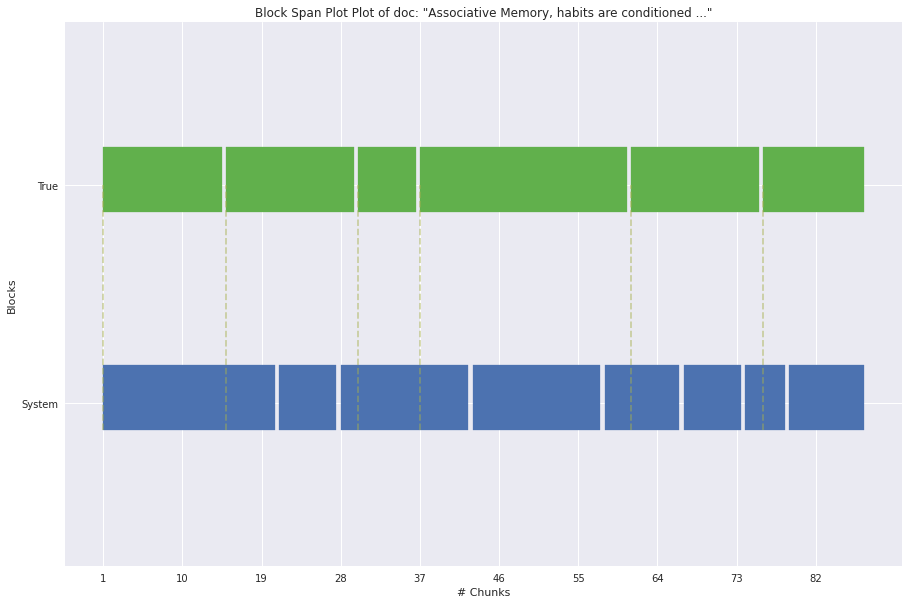

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
viz.block_span_plot(ax, doc, true_breakpoints, system_breakpoints)

### Batch evaluation

TODO eseguire su tutti i testi la pipeline precedente e trovare un modo per sommarizzare i risultati ottentuti

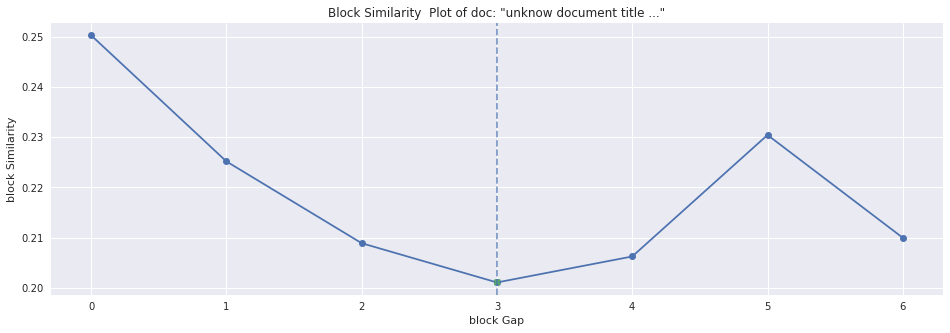

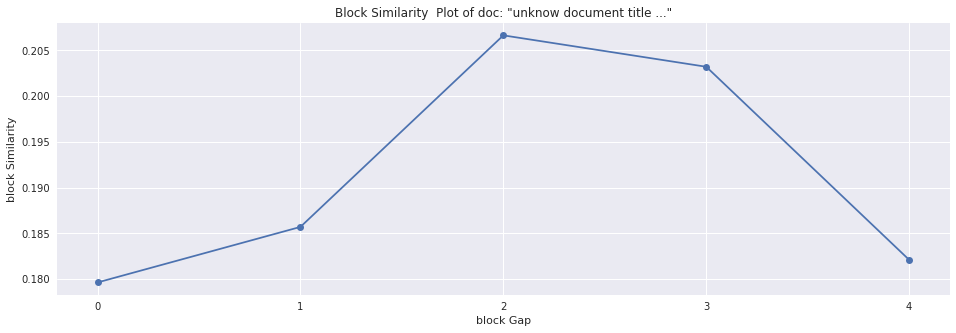

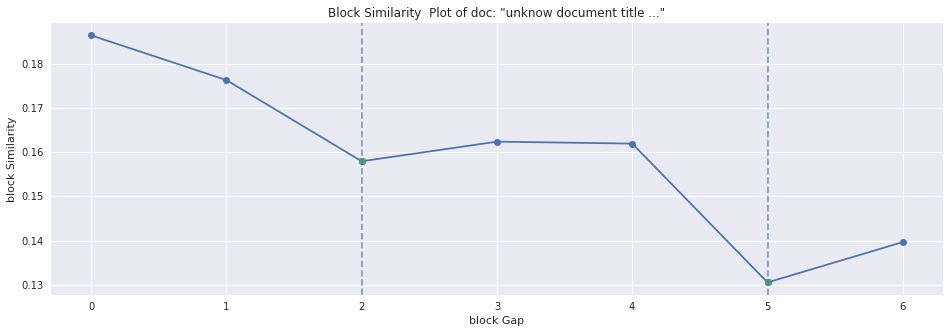

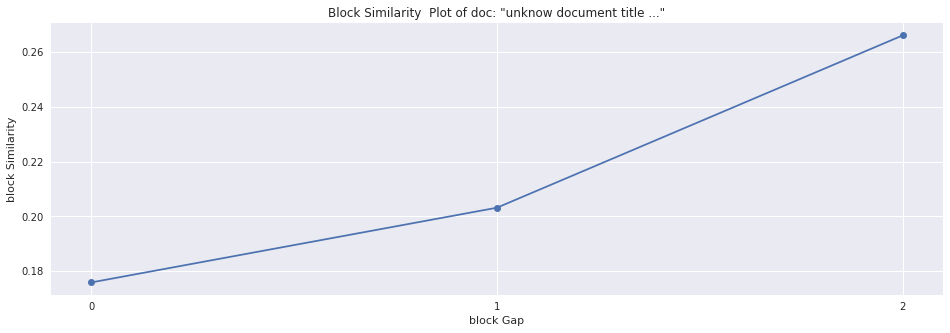

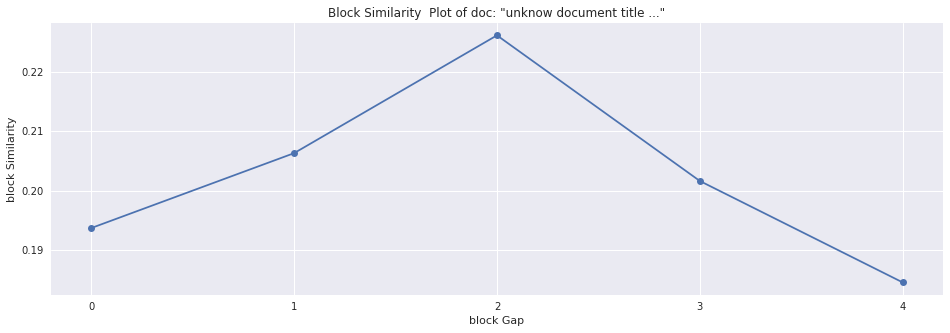

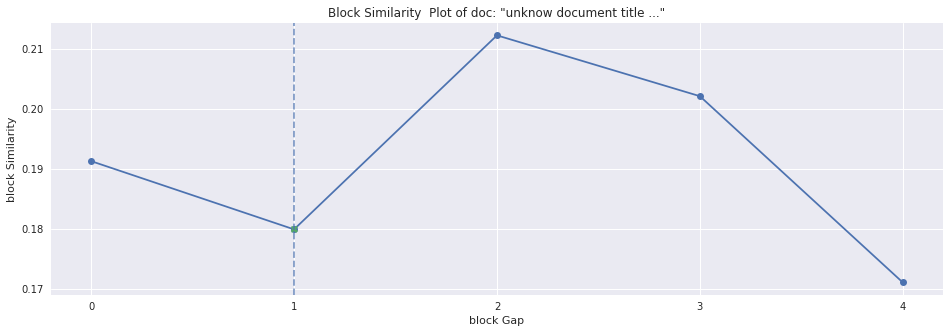

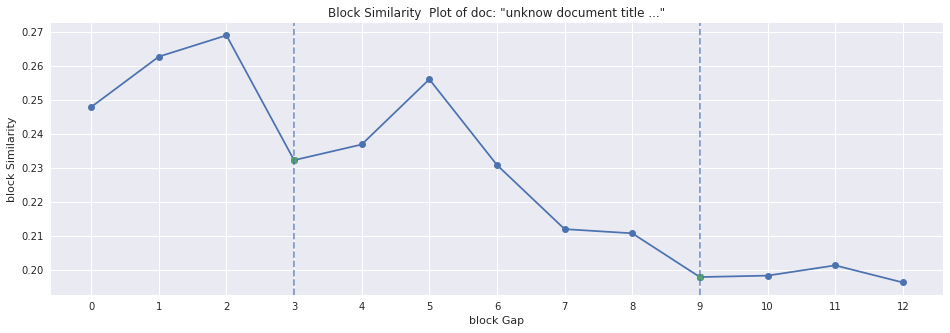

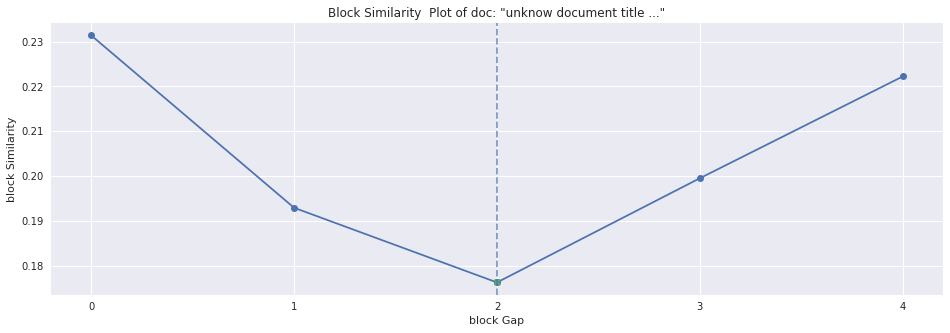

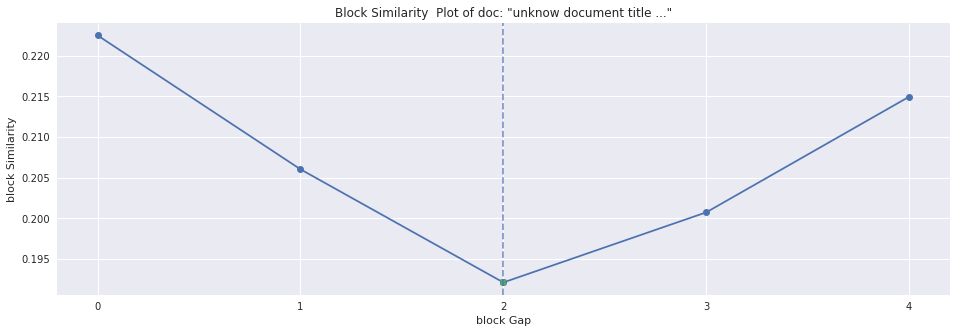

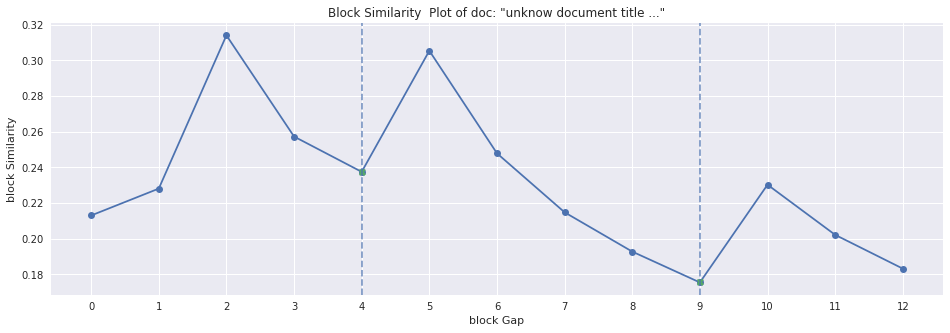

In [18]:
import random
random.seed(10)

N_DOCS = 10

doc_paths = list(filter(lambda x: x.is_file(), Path("data/WIKI-727K-subset").rglob("*")))
doc_paths = random.sample(doc_paths, N_DOCS)

docs = [dm.Document(doc_path, nltk.sent_tokenize) for doc_path in doc_paths]
segmenter = segm.TextSegmenter(segm.preprocessor, glove, segm.cosine_similarity)


for doc in docs:
    INITIAL_BLOCKS = len(doc.get_breakpoints()) * 2 # this is an unfair trick!!!
    minima, similarities, blocks = segmenter.segment(doc, initial_blocks=INITIAL_BLOCKS)
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    viz.block_similarity_plot(ax, doc, minima, similarities)


Possibili estensioni

* rendere il numero di blocchi iniziali adattivo
* permettere di poter incrementare e decrementare il numbero di breakpoints ==> meccanismi di merging e splitting ricorsivo
* 